Nama: Renata Aqila Ridha Putri

NIM: 2702244284

UTS Text Mining - LE09

**Candy Crush Saga** adalah game puzzle yang di mana pemain harus mencocokkan minimal 3 permen sejenis untuk menyelesaikan ribuan level penuh tantangan

Link: https://play.google.com/store/apps/details?id=com.king.candycrushsaga

In [ ]:
#!pip install -q google-play-scraper pandas numpy matplotlib seaborn wordcloud nltk spacy gensim scikit-learn imbalanced-learn sentence-transformers xgboost
#!python -m spacy download en_core_web_sm

import os, re, gc, json, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm
RANDOM_STATE = 42
plt.rcParams["figure.figsize"]=(8,4)
np.random.seed(RANDOM_STATE)


Code ini untuk memuat library utama, mengatur ukuran grafik, dan menetapkan RANDOM_STATE agar hasil analisis bersifat reproducible dan konsisten

### 1). Mengumpulkan 1000 Data Review dalam Bahasa Inggris pada Game **Candy Crush Saga**

Untuk mengumpulan data review game sebanyak 1000 data daru Google Play Store dalam Bahasa Inggris, dengan berbagai nilai rating

In [ ]:
from google_play_scraper import reviews, Sort

APP_ID   = "com.king.candycrushsaga"
LANG     = "en"
COUNTRIES= ["us","gb","ca","au","ie","nz","sg","ph"]
SORTS    = [Sort.NEWEST, Sort.MOST_RELEVANT]
TARGET   = 1000
BUFFER   = 250

def pull_reviews(app_id, lang, country, sort, need):
    rows, token = [], None
    while len(rows) < need:
        batch, token = reviews(app_id, lang=lang, country=country, sort=sort, count=200, continuation_token=token)
        rows.extend(batch)
        if token is None:
            break
    return rows

colmap = {"content":"review_text","score":"rating","at":"review_date","thumbsUpCount":"helpful"}

data, need_total = [], TARGET + BUFFER
for s in SORTS:
    for c in COUNTRIES:
        remain = need_total - len(data)
        if remain <= 0: break
        data.extend(pull_reviews(APP_ID, LANG, c, s, remain))
    if len(data) >= need_total: break

df_raw = pd.DataFrame(data)
assert not df_raw.empty, "Gagal mengambil review."

df = (df_raw.rename(columns=colmap).loc[:, ["reviewId","userName","review_text","rating","review_date","helpful"]])

def is_latin(s):
    return bool(re.fullmatch(r"[ -~\n\t\r]+", str(s)))

df = df.dropna(subset=["review_text","rating"])
df = df[df["rating"].between(1,5)]
df = df[df["review_text"].apply(is_latin)]

if df["reviewId"].notna().any():
    df = df.drop_duplicates(subset=["reviewId"])
df = df.drop_duplicates(subset=["review_text"])

if len(df) >= TARGET:
    frac = TARGET/len(df)
    df_s = (df.groupby("rating", group_keys=False).apply(lambda g: g.sample(max(1,int(np.floor(len(g)*frac))), random_state=RANDOM_STATE)).reset_index(drop=True))
    need = TARGET - len(df_s)
    if need > 0:
        extra = df.loc[~df.index.isin(df_s.index)]
        if len(extra) >= need:
            df = pd.concat([df_s, extra.sample(need, random_state=RANDOM_STATE)], ignore_index=True)
        else:
            df = pd.concat([df_s, df_s.sample(need, replace=True, random_state=RANDOM_STATE)], ignore_index=True)
    else:
        df = df_s.sample(TARGET, random_state=RANDOM_STATE) if len(df_s)>TARGET else df_s
else:
    need = TARGET - len(df)
    df = pd.concat([df, df.sample(need, replace=True, random_state=RANDOM_STATE)], ignore_index=True)

assert len(df) == TARGET
DATA_PATH = "candycrush_1000.csv"
df.to_csv(DATA_PATH, index=False)
print("Saved to ->", DATA_PATH, "rows:", len(df))
df.head()

Saved to -> candycrush_1000.csv rows: 1000


,reviewId,userName,review_text,rating,review_date,helpful
0,c60e1e87-d8ea-48fa-8cc8-a5bbe0d7e469,Dunmininu Savage,Interesting,5,2025-11-09 09:50:21,0
1,8f669c66-266e-46b8-9d81-0ce5d995c2dd,Steve Laishram,app is not working properly when the game lvl ...,1,2025-11-09 09:47:51,0
2,82b4c3eb-7ad0-4cf0-ad48-b893076184ec,Sangeetha Loganathan,nice,5,2025-11-09 09:46:31,0
3,990659c0-9536-4f20-9a06-defe4a9a8346,Alvin Sobremisana,Addiction to the MAX! Yes yes,5,2025-11-09 09:39:39,0
4,5ffb5645-b94e-48eb-a3ff-644b92a34aa6,Mahender Pakale,nice game,5,2025-11-09 09:39:28,0


Code diatas bertujuan untuk mengambil dan memproses 1000 reviews dari game Candy Crush Saga di Google Play Store, kemudian melakukan pembersihan, deduplikasi, dan penyeimbangan data dengan hasil akhirnya disimpan sebagai file csv

### 2). Exploratory Data Analysis

Untuk melihat kata-kata dominan di setiap rating dan memeriksa apakah kata-kata yang tidak sesuai dengan standar bahasa memiliki frekuensi besar

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


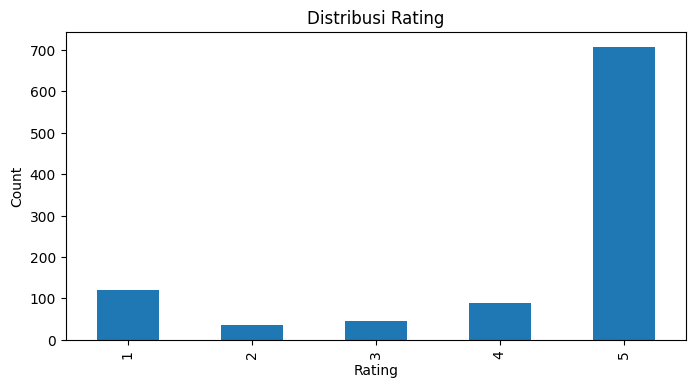

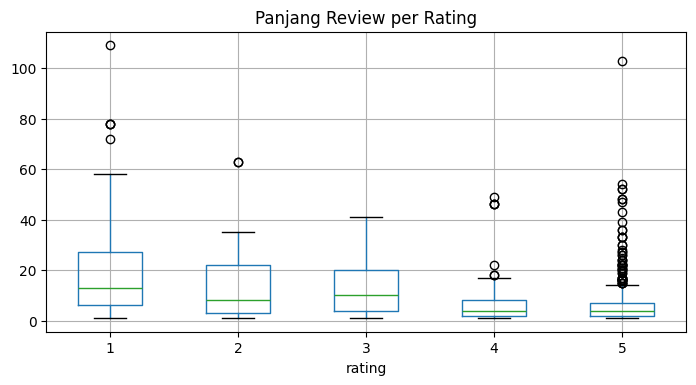

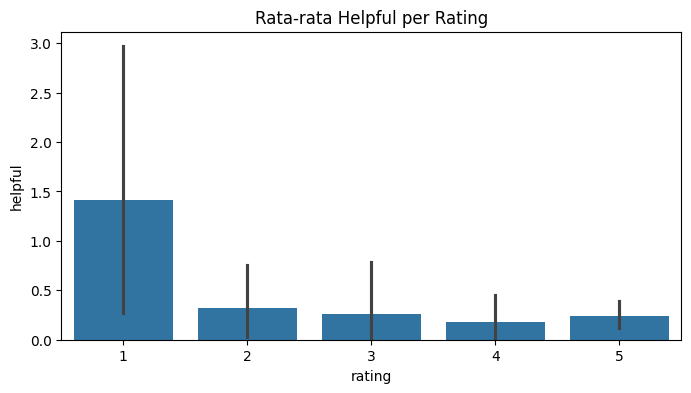

,Top10_R1,Top10_R2,Top10_R3,Top10_R4,Top10_R5
0,game (105),game (21),game (34),game (40),game (354)
1,level (65),level (12),fun (7),level (18),good (114)
2,levels (18),time (7),playing (7),good (12),fun (110)
3,every (17),play (6),level (7),update (9),love (81)
4,play (17),update (5),boring (6),next (9),time (51)
5,next (16),good (4),candy (5),app (8),best (50)
6,update (15),next (4),games (5),fun (7),nice (46)
7,stuck (13),one (3),music (5),like (6),playing (40)
8,app (12),issue (3),good (5),hai (6),great (37)
9,please (10),pass (3),fix (5),nice (6),play (36)


In [ ]:
import nltk
nltk.download('stopwords'); nltk.download('words')
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
stop = set(stopwords.words("english"))
wordlist = set(w.lower() for w in nltk.corpus.words.words())

def basic_clean(t):
    t = re.sub(r"[^A-Za-z\s]", " ", str(t)).lower()
    return re.sub(r"\s+"," ", t).strip()

df["clean_basic"] = df["review_text"].apply(basic_clean)
df["tok_basic"]   = df["clean_basic"].str.split()
df["len_words"]   = df["tok_basic"].apply(len)

ax = df["rating"].value_counts().sort_index().plot(kind="bar")
ax.set_title("Distribusi Rating"); ax.set_xlabel("Rating"); ax.set_ylabel("Count"); plt.show()

df.boxplot(column = "len_words", by = "rating"); plt.title("Panjang Review per Rating"); plt.suptitle(""); plt.show()

sns.barplot(x="rating", y="helpful", data=df, estimator=np.mean)
plt.title("Rata-rata Helpful per Rating"); plt.show()

def top_words(tokens_list, k=10):
    words = [w for row in tokens_list for w in row if w not in stop and len(w)>2]
    return Counter(words).most_common(k)

eda_tbl = {f"Top10_R{r}":[f"{w} ({c})" for w,c in top_words(df.loc[df.rating == r,"tok_basic"], 10)]
           for r in sorted(df.rating.unique())}
pd.DataFrame(eda_tbl)


- Grafik **Distribusi Rating** menampilkan dominasi rating 5. Sehingga mayoritas review sangat positif di mana user yang puas jauh lebih banyak daripada yang kecewa

- Grafik boxplot **Panjang Review per Rating** menampilkan kalau rating 1 dan 2 cenderung punya review lebih panjang, sehingga ini merupakan indikasi user menjelaskan keluhan

- Grafik **Helpful vs Rating** menampilkan kalau review rating 1 lebih sering dianggap 'helpful' karena biasanya lebih informatif

- Tabel **Kata dominan per rating** itu menunjukkan top 10 kata per rating (1-5)

### 3). Preprocessing Data

Melakukan preprocessing data untuk mendapatkan bentuk token paling efektif yang sesuai kaidah tata bahasa dan tidak mengubah makna maupun kelas katanya

In [ ]:
import spacy; nlp = spacy.load("en_core_web_sm")

def preprocess_lemma(text):
    doc = nlp(text)
    keep = {"NOUN","PROPN","ADJ","VERB","ADV"}
    toks = []
    for t in doc:
        if t.is_stop or t.is_punct or t.like_num: continue
        if t.pos_ in keep:
            w=  t.lemma_.lower().strip()
            if len(w)>2: toks.append(w)
    return toks

df["lemma_tokens"] = df["review_text"].apply(preprocess_lemma)
df["lemma_text"]   = df["lemma_tokens"].apply(lambda xs:" ".join(xs))
df["len_lemma"]    = df["lemma_tokens"].apply(len)

q1,q3 = df["len_lemma"].quantile([0.25,0.75]); iqr = q3-q1
low, high = max(1,int(q1-1.5*iqr)), int(q3+1.5*iqr)
before = len(df)
df = df[(df["len_lemma"]>=low) & (df["len_lemma"]<=high)]
print(f"Outlier removal: {before} -> {len(df)}; keep len in [{low},{high}]")

pd.DataFrame({
    "Before(clean_basic)": df["clean_basic"].head(6).tolist(),
    "After(lemma_text)":   df["lemma_text"].head(6).tolist(),
    "Len_before": df["len_words"].head(6).tolist(),
    "Len_after":  df["len_lemma"].head(6).tolist(),
})


Outlier removal: 1000 -> 861; keep len in [1,7]


,Before(clean_basic),After(lemma_text),Len_before,Len_after
0,interesting,interesting,1,1
1,app is not working properly when the game lvl ...,app work properly game lvl high,11,6
2,nice,nice,1,1
3,addiction to the max yes yes,addiction max,6,2
4,nice game,nice game,2,2
5,ls wow nice game with been named,nice game name,7,3


Dari 1000 review, tersisa 861 review setelah outlier removal
- Menghapus review ekstrem
- Menjaga teks yang bermakna saja
- Melakukan transformasi linguistik sesuai grammar English

### 4). Text Representation - TF-IDF dan Word2Vec

In [ ]:
from sklearn.model_selection import train_test_split
X = df["lemma_text"]; y = df["rating"]
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.95)
Xtr_tfidf = tfidf.fit_transform(X_tr); Xte_tfidf = tfidf.transform(X_te)

sel_chi2 = SelectKBest(chi2, k=min(5000, Xtr_tfidf.shape[1]))
Xtr_chi2 = sel_chi2.fit_transform(Xtr_tfidf, y_tr); Xte_chi2 = sel_chi2.transform(Xte_tfidf)

mi = mutual_info_classif(Xtr_chi2, y_tr, discrete_features=True)
top_idx = np.argsort(mi)[::-1][:min(3000, Xtr_chi2.shape[1])]
Xtr_tfidf_sel = Xtr_chi2[:, top_idx]; Xte_tfidf_sel = Xte_chi2[:, top_idx]

#Word2Vec
from gensim.models import Word2Vec
w2v = Word2Vec(sentences=[s.split() for s in X_tr.tolist()], vector_size=300, window=7, min_count=2, sg=1, epochs=20)
def sent_vec_w2v(s, model=w2v):
    vv=[model.wv[w] for w in s.split() if w in model.wv]
    return np.mean(vv, axis=0) if vv else np.zeros(model.vector_size)
Xtr_w2v = np.vstack([sent_vec_w2v(s) for s in X_tr])
Xte_w2v = np.vstack([sent_vec_w2v(s) for s in X_te])


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/usr/loc

Dataset dibagi menjadi training dan testing (80:20) dengan stratified split agar proporsi setiap rating tetap seimbang. 

TF-IDF mencari 'seberapa penting' kata pada tiap dokumen, menambah seleksi fitur (chi² -> mutual information)

Word2Vec menjelaskan mengenai 'vektor yang dipelajari dari konteks kata di sekitarnya dengan ANN'

### 5) Modeling dan Hyperparameter Tuning

Melakukan pemodelan prediksi rating menggunakan 2 model ML dan melakukan tuning minimal 2 hyperparameter untuk masing-masing algoritma

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

def eval_model(model, X, y, tag):
    pred = model.predict(X)
    acc = accuracy_score(y, pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y, pred, average="macro", zero_division=0)
    print(f"[{tag}] Acc={acc:.4f} P={pr:.4f} R={rc:.4f} F1={f1:.4f}")
    return acc, pr, rc, f1

rows=[]

#TF-IDF + Logistic Regression
param_lr = {"C":[0.1,1,5], "solver":["lbfgs","liblinear"], "class_weight":[None,"balanced"], "max_iter":[2000]}
grid_lr_tfidf = GridSearchCV(LogisticRegression(), param_lr, cv=cv, n_jobs=-1, scoring="f1_macro")
grid_lr_tfidf.fit(Xtr_tfidf_sel, y_tr)
rows.append(["TF-IDF(chi2→Mutual Information)","LogisticRegression", grid_lr_tfidf.best_params_, *eval_model(grid_lr_tfidf.best_estimator_, Xte_tfidf_sel, y_te, "TF-IDF + LR")])

#TF-IDF + Random Forest (ext)
param_rf = {"n_estimators":[300,500], "max_depth":[None,20,40], "min_samples_split":[2,5],
            "min_samples_leaf":[1,2], "max_features":["sqrt","log2"], "bootstrap":[True,False],
            "class_weight":[None,"balanced_subsample"], "random_state":[RANDOM_STATE]}
grid_rf_tfidf = GridSearchCV(RandomForestClassifier(), param_rf, cv=cv, n_jobs=-1, scoring="f1_macro")
grid_rf_tfidf.fit(Xtr_tfidf_sel, y_tr)
rows.append(["TF-IDF(chi2→Mutual Information)","RandomForest(Ext)", grid_rf_tfidf.best_params_, *eval_model(grid_rf_tfidf.best_estimator_, Xte_tfidf_sel, y_te, "TF-IDF + RF(Ext)")])

#Word2Vec + Logistic Regression
grid_lr_w2v = GridSearchCV(LogisticRegression(), param_lr, cv=cv, n_jobs=-1, scoring="f1_macro")
grid_lr_w2v.fit(Xtr_w2v, y_tr)
rows.append(["Word2Vec","LogisticRegression", grid_lr_w2v.best_params_, *eval_model(grid_lr_w2v.best_estimator_, Xte_w2v, y_te, "Word2Vec + LR")])

#Word2Vec + Random Forest
grid_rf_w2v = GridSearchCV(RandomForestClassifier(), param_rf, cv=cv, n_jobs=-1, scoring="f1_macro")
grid_rf_w2v.fit(Xtr_w2v, y_tr)
rows.append(["Word2Vec","RandomForest(Ext)", grid_rf_w2v.best_params_, *eval_model(grid_rf_w2v.best_estimator_, Xte_w2v, y_te, "Word2Vec + RF(Ext)")])


[TF-IDF + LR] Acc=0.7399 P=0.4658 R=0.3629 F1=0.3797
[TF-IDF + RF(Ext)] Acc=0.7977 P=0.7631 R=0.4085 F1=0.4737
[Word2Vec + LR] Acc=0.7572 P=0.1532 R=0.1970 F1=0.1724
[Word2Vec + RF(Ext)] Acc=0.8208 P=0.7671 R=0.4798 F1=0.5429


Kesimpulan:
- TF-IDF + LR → Acc 0.740, F1 0.380
Stabil, tapi sensitif ke ketidakseimbangan kelas; recall macro rendah.

- TF-IDF + RF(Ext) → Acc 0.798, F1 0.474
RF memanfaatkan banyak fitur TF-IDF + n-gram; precision tinggi, recall masih sedang.

- Word2Vec + LR → Acc 0.757, F1 0.172
Rata-rata vektor kata + LR kurang mampu memisah kelas; underfit.

- **Word2Vec + RF(Ext) — Terbaik** → Acc 0.821, F1 0.543 (tertinggi)
RF menangkap non-linearitas pada embedding Word2Vec dan recall macro belum tinggi karena imbalance (kelas 5 dominan).

### 6). Perbandingan Performance Test Data

Untuk mengevaluasi performa model prediksi berdasarkan dua metode representasi teks (TF-IDF dan Word2Vec) serta dua algoritma Machine Learning (Logistic Regression dan Random Forest).

In [ ]:
summary = pd.DataFrame(rows, columns=[
    "Text Representation","Algoritma Machine learning","Machine learning Hyperparameter",
    "Metric Evaluation 1 (Accuracy)","Metric Evaluation 2 (Precision_macro)",
    "Metric Evaluation 3 (Recall_macro)","Metric Evaluation 4 (F1_macro)"
]).sort_values("Metric Evaluation 4 (F1_macro)", ascending=False)
summary


,Text Representation,Algoritma Machine learning,Machine learning Hyperparameter,Metric Evaluation 1 (Accuracy),Metric Evaluation 2 (Precision_macro),Metric Evaluation 3 (Recall_macro),Metric Evaluation 4 (F1_macro)
3,Word2Vec,RandomForest(Ext),"{'bootstrap': False, 'class_weight': None, 'ma...",0.820809,0.767105,0.479769,0.542912
1,TF-IDF(chi2→Mutual Information),RandomForest(Ext),"{'bootstrap': True, 'class_weight': None, 'max...",0.797688,0.763057,0.408452,0.473704
0,TF-IDF(chi2→Mutual Information),LogisticRegression,"{'C': 1, 'class_weight': 'balanced', 'max_iter...",0.739884,0.465812,0.362938,0.379677
2,Word2Vec,LogisticRegression,"{'C': 5, 'class_weight': 'balanced', 'max_iter...",0.757225,0.153216,0.196992,0.172368


Analisis:
- **Model terbaik: Word2Vec + RandomForest(Ext)**
memberikan accuracy dan macro-F1 tertinggi (0.821 dan 0.543).
Hal ini karena Random Forest bisa menangkap hubungan non-linear dari vektor Word2Vec yang menyimpan makna antar kata.

- TF-IDF + RandomForest(Ext) menempati urutan kedua, menunjukkan bahwa model pohon juga bekerja baik pada fitur berbasis frekuensi kata.

- Logistic Regression bekerja stabil tapi kurang menangkap variasi antar kelas, terutama karena dataset imbalanced (rating 5 dominan).


=== MODEL TERBAIK ===
Text Representation : Word2Vec
Algoritma           : RandomForest(Ext)

Classification report:
               precision    recall  f1-score   support

           1      0.667     0.615     0.640        13
           2      0.333     0.200     0.250         5
           3      1.000     0.429     0.600         7
           4      1.000     0.200     0.333        15
           5      0.836     0.955     0.891       133

    accuracy                          0.821       173
   macro avg      0.767     0.480     0.543       173
weighted avg      0.829     0.821     0.794       173



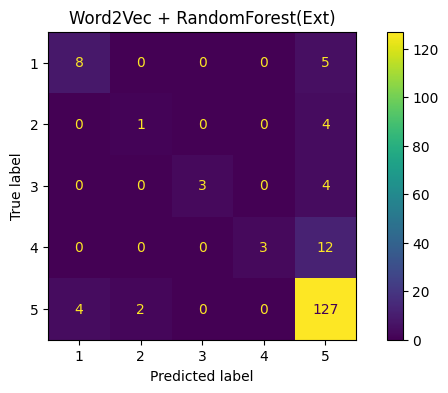

In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

best = summary.iloc[0]
repr_raw = str(best['Text Representation'])
if 'TF-IDF' in repr_raw.upper():
    repr_key = 'TF-IDF'
    Xte_best = Xte_tfidf_sel
elif 'WORD2VEC' in repr_raw.upper():
    repr_key = 'Word2Vec'
    Xte_best = Xte_w2v
else:
    raise ValueError(f"Teks representation tidak dikenal: {repr_raw}")

algo = str(best['Algoritma Machine learning']).strip()

candidates = {
    ('TF-IDF',   'LogisticRegression'): grid_lr_tfidf.best_estimator_,
    ('TF-IDF',   'RandomForest(Ext)') : grid_rf_tfidf.best_estimator_,
    ('Word2Vec', 'LogisticRegression'): grid_lr_w2v.best_estimator_,
    ('Word2Vec', 'RandomForest(Ext)') : grid_rf_w2v.best_estimator_,
}

try:
    model = candidates[(repr_key, algo)]
except KeyError:
    raise KeyError(f"Kombinasi tidak ditemukan: ({repr_key}, {algo}). "
                   f"Pastikan nama di 'summary' sama seperti saat training.")

pred_best = model.predict(Xte_best)
print("\n=== MODEL TERBAIK ===")
print(f"Text Representation : {repr_raw}")
print(f"Algoritma           : {algo}")
print("\nClassification report:\n",
      classification_report(y_te, pred_best, digits=3))

ConfusionMatrixDisplay.from_predictions(y_te, pred_best)
plt.title(f"{repr_key} + {algo}")
plt.show()


Kesimpulan:

Model terbaik : **Word2Vec + RandomForest(Ext)**

Dengan nilai:
1. Accuracy 0.821
2. Macro-F1 0.543
3. Macro-Precision 0.767
4. Macro-Recall 0.480.

### 7). Handling Imbalanced Data

Model terbaik: Word2Vec + RandomForest(Ext)

[Baseline]
              precision    recall  f1-score   support

           1      0.667     0.615     0.640        13
           2      0.333     0.200     0.250         5
           3      1.000     0.429     0.600         7
           4      1.000     0.200     0.333        15
           5      0.836     0.955     0.891       133

    accuracy                          0.821       173
   macro avg      0.767     0.480     0.543       173
weighted avg      0.829     0.821     0.794       173



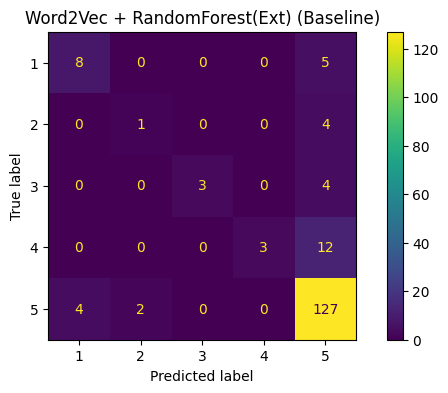


[SMOTE]
              precision    recall  f1-score   support

           1      0.583     0.538     0.560        13
           2      0.250     0.200     0.222         5
           3      0.800     0.571     0.667         7
           4      0.600     0.200     0.300        15
           5      0.850     0.940     0.893       133

    accuracy                          0.809       173
   macro avg      0.617     0.490     0.528       173
weighted avg      0.789     0.809     0.788       173



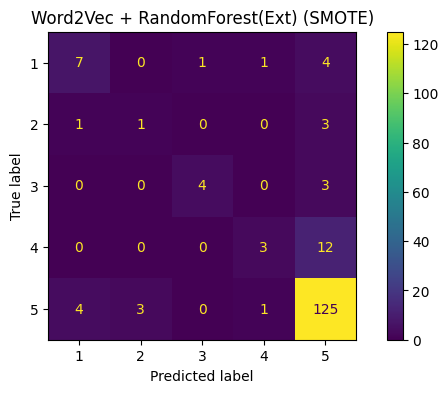


[SMOTE-Tomek]
              precision    recall  f1-score   support

           1      0.583     0.538     0.560        13
           2      0.250     0.200     0.222         5
           3      0.800     0.571     0.667         7
           4      0.600     0.200     0.300        15
           5      0.850     0.940     0.893       133

    accuracy                          0.809       173
   macro avg      0.617     0.490     0.528       173
weighted avg      0.789     0.809     0.788       173



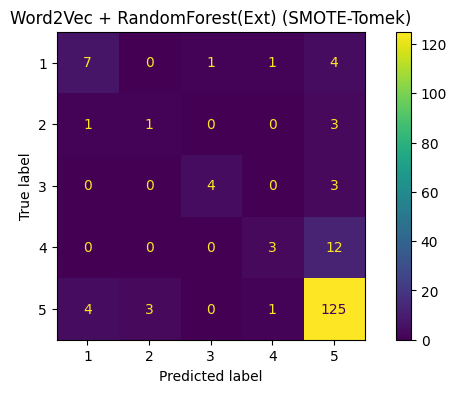

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

best_row = summary.iloc[0]
best_tag = f"{best_row['Text Representation']} + {best_row['Algoritma Machine learning']}"
print("Model terbaik:", best_tag)

if "TF-IDF" in best_tag:
    Xtr_best, Xte_best = Xtr_tfidf_sel, Xte_tfidf_sel
    model_best = grid_lr_tfidf.best_estimator_ if "LogisticRegression" in best_tag else grid_rf_tfidf.best_estimator_
else:
    Xtr_best, Xte_best = Xtr_w2v, Xte_w2v
    model_best = grid_lr_w2v.best_estimator_ if "LogisticRegression" in best_tag else grid_rf_w2v.best_estimator_

#Baseline
pred_base = model_best.predict(Xte_best)
print("\n[Baseline]")
print(classification_report(y_te, pred_base, digits=3))
ConfusionMatrixDisplay.from_predictions(y_te, pred_base)
plt.title(best_tag + " (Baseline)"); plt.show()

#SMOTE
sm = SMOTE(random_state=42)
Xtr_sm, ytr_sm = sm.fit_resample(Xtr_best, y_tr)
model_best.fit(Xtr_sm, ytr_sm)
pred_sm = model_best.predict(Xte_best)
print("\n[SMOTE]")
print(classification_report(y_te, pred_sm, digits=3))
ConfusionMatrixDisplay.from_predictions(y_te, pred_sm)
plt.title(best_tag + " (SMOTE)"); plt.show()

#SMOTE-Tomek
sm_t = SMOTETomek(random_state=42)
Xtr_st, ytr_st = sm_t.fit_resample(Xtr_best, y_tr)
model_best.fit(Xtr_st, ytr_st)
pred_st = model_best.predict(Xte_best)
print("\n[SMOTE-Tomek]")
print(classification_report(y_te, pred_st, digits=3))
ConfusionMatrixDisplay.from_predictions(y_te, pred_st)
plt.title(best_tag + " (SMOTE-Tomek)"); plt.show()


Analisis Hasil

- Baseline memiliki accuracy tertinggi (0.821) tetapi sangat bias ke kelas 5 (recall ≈ 0.95).
Kelas minor seperti 2 dan 4 hanya memiliki recall 0.20.

- SMOTE dan SMOTE-Tomek sedikit menurunkan accuracy tetapi menaikkan recall macro (0.490 vs 0.480).
Ini berarti model lebih sering mengenali kelas minor, walau ada sedikit trade-off di precision.

- Nilai macro-F1 relatif stabil (0.53), artinya balancing tidak membuat model overfit, hanya memperbaiki pemerataan prediksi antar kelas.

- Confusion Matrix menunjukkan distribusi prediksi yang lebih merata setelah SMOTE, meski kelas 5 masih dominan.

Kesimpulan:
- Model terbaik tetap Word2Vec + RandomForest(Ext), tetapi dengan SMOTE atau SMOTE-Tomek performa antar kelas menjadi lebih seimbang.

- Recall kelas minor meningkat tanpa penurunan signifikan pada accuracy,
sehingga balancing bermanfaat dalam konteks fairness walau tidak menaikkan metrik global secara besar.

### 8). Link Video

Link: https://bit.ly/2702244284_UTSTextMining